In [1]:
%%capture
!pip install pytorch-lightning
!pip install pytorchmetrics
!pip install celluloid
!pip install imgaug==0.4.0

import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm.notebook import tqdm
from pathlib import Path
from celluloid import Camera
import nibabel as nib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from IPython.display import HTML
from warnings import filterwarnings
filterwarnings("ignore")

from google.colab import drive
drive.mount("/content/drive")

import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation.zip", mode = "r")
zip_file.extractall()
zip_file.close()

In [3]:
!tar -xvf /content/drive/MyDrive/PyTorch_Vol3/Task06_Lung.tar

Task06_Lung/._dataset.json
Task06_Lung/dataset.json
Task06_Lung/._imagesTr
Task06_Lung/imagesTr/
Task06_Lung/imagesTr/._lung_053.nii.gz
Task06_Lung/imagesTr/lung_053.nii.gz
Task06_Lung/imagesTr/._lung_022.nii.gz
Task06_Lung/imagesTr/lung_022.nii.gz
Task06_Lung/imagesTr/._lung_041.nii.gz
Task06_Lung/imagesTr/lung_041.nii.gz
Task06_Lung/imagesTr/._lung_069.nii.gz
Task06_Lung/imagesTr/lung_069.nii.gz
Task06_Lung/imagesTr/._lung_014.nii.gz
Task06_Lung/imagesTr/lung_014.nii.gz
Task06_Lung/imagesTr/._lung_006.nii.gz
Task06_Lung/imagesTr/lung_006.nii.gz
Task06_Lung/imagesTr/._lung_065.nii.gz
Task06_Lung/imagesTr/lung_065.nii.gz
Task06_Lung/imagesTr/._lung_018.nii.gz
Task06_Lung/imagesTr/lung_018.nii.gz
Task06_Lung/imagesTr/._lung_096.nii.gz
Task06_Lung/imagesTr/lung_096.nii.gz
Task06_Lung/imagesTr/._lung_084.nii.gz
Task06_Lung/imagesTr/lung_084.nii.gz
Task06_Lung/imagesTr/._lung_086.nii.gz
Task06_Lung/imagesTr/lung_086.nii.gz
Task06_Lung/imagesTr/._lung_043.nii.gz
Task06_Lung/imagesTr/lung_04

In [4]:
root = Path("/content/Task06_Lung/imagesTr")
label = Path("/content/Task06_Lung/labelsTr")

In [5]:
def change_img_to_label_path(path):

    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"

    return Path(*parts)

In [6]:
root,change_img_to_label_path(root)

(PosixPath('/content/Task06_Lung/imagesTr'),
 PosixPath('/content/Task06_Lung/labelsTr'))

In [7]:
sample_path = list(root.glob("lung*"))[2]
sample_path_label = change_img_to_label_path(sample_path)
sample_path, sample_path_label

(PosixPath('/content/Task06_Lung/imagesTr/lung_018.nii.gz'),
 PosixPath('/content/Task06_Lung/labelsTr/lung_018.nii.gz'))

In [8]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [9]:
nib.aff2axcodes(data.affine),nib.aff2axcodes(label.affine)

(('L', 'A', 'S'), ('L', 'A', 'S'))

In [10]:
ct.shape, mask.shape

((512, 512, 273), (512, 512, 273))

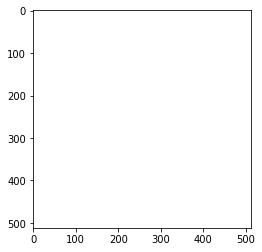

In [11]:
fig = plt.figure()
camera = Camera(fig)

for i in range(0, ct.shape[2], 2):

    plt.imshow(ct[:, :, i], cmap = "bone")
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha = 0.5, cmap = "autumn")
    camera.snap()

animation = camera.animate()

In [12]:
HTML(animation.to_html5_video())

In [13]:
all_files = list(root.glob("lung_*"))
len(all_files)

63

In [27]:
all_files[2]

PosixPath('/content/Task06_Lung/imagesTr/lung_018.nii.gz')

In [14]:
save_root = Path("/content/Task06_Lung/Preprocessed/")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_ct_data)

    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()

    ct_data = ct_data[:, :, 30:] / 3071
    label_data = label_data[:, :, 30:]

    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    for i in range(ct_data.shape[-1]):

        slice = ct_data[: ,:, i]
        mask = label_data[:, :, i]

        slice = cv2.resize(slice , (256,256))
        mask = cv2.resize(mask, (256,256), interpolation = cv2.INTER_NEAREST)

        slice_path = current_path/"data"
        mask_path = current_path/"masks"

        slice_path.mkdir(parents = True, exist_ok = True)
        mask_path.mkdir(parents = True, exist_ok = True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

  0%|          | 0/63 [00:00<?, ?it/s]

In [43]:
path = Path("/content/Task06_Lung/Preprocessed/train/2")
list(path.glob("*"))

[PosixPath('/content/Task06_Lung/Preprocessed/train/2/data'),
 PosixPath('/content/Task06_Lung/Preprocessed/train/2/masks')]

In [46]:
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

slice.shape,mask.shape

((256, 256), (256, 256))

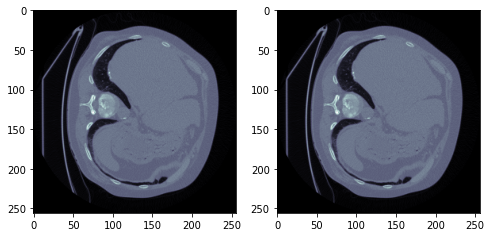

In [47]:
fig , axis = plt.subplots(1,2,figsize= (8,8))
axis[0].imshow(slice, cmap = "bone")
mask_ = np.ma.masked_where(mask == 0, mask)

axis[1].imshow(slice, cmap = "bone")
axis[1].imshow(mask_, alpha = 0.5,cmap = "autumn")
plt.show()

In [48]:
print(slice.min(), slice.max())

-0.33344187561055033 0.3835070009768805


---

In [49]:
class LungDataset(torch.utils.data.Dataset):

    def __init__(self,root,augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):

        files = []
        for subject in root.glob("*"):
            slice_path = subject/"data"
            for slice in slice_path.glob("*"):
                files.append(slice)
        return files

    @staticmethod
    def change_img_to_label_path(path):

        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):

        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image = slice, segmentation_maps = mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):

        return len(self.all_files)

    def __getitem__(self,idx):

        file_path = self.all_files[idx] 
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path)
        mask = np.load(mask_path)

        if self.augment_params:
            slice , mask = self.augment(slice, mask)

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [50]:
seq = iaa.Sequential([
                      iaa.Affine(scale = (0.85, 1.15),
                                 rotate = (-45,45)),
                      iaa.ElasticTransformation()
])

In [51]:
path = Path("/content/Task06_Lung/Preprocessed/train/")
path

PosixPath('/content/Task06_Lung/Preprocessed/train')

In [52]:
dataset = LungDataset(path, seq)

In [53]:
len(dataset)

14366

In [59]:
slice, mask = dataset[19]
slice.shape, mask.shape

((1, 256, 256), (1, 256, 256))

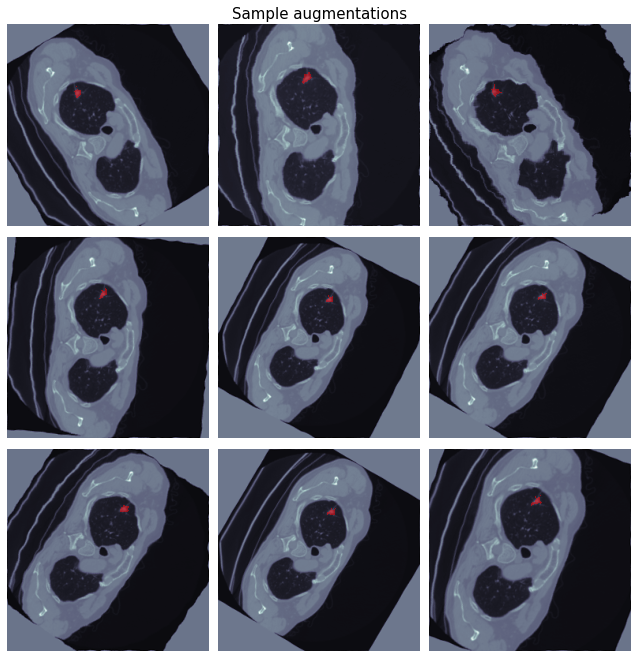

In [68]:
fig, axis = plt.subplots(3,3,figsize = (9,9))

axis = axis.ravel()

for i in range(len(axis)):

        slice, mask = dataset[70]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i].imshow(slice[0], cmap="bone")
        axis[i].imshow(mask_[0], alpha = 0.5 ,cmap = "autumn")
        axis[i].axis("off")

fig.suptitle("Sample augmentations",y = 1.01,fontsize = 15)
plt.tight_layout()
plt.show()

----

In [70]:
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU())    
    def forward(self, X):
        return self.step(X)

In [71]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 64)  # MRI -> One channel
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)  # Binary label -> One class 
        #########################################

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        
        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################
        
        ####### DownConv 2#########        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################
        
        ##### Intermediate Layer ## 
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########        
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)  # Upsample with a factor of 2
        #x5 = torch.nn.ConvTranspose2d(512, 512, 2, 2)(x4)
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)        
        #x6 = torch.nn.ConvTranspose2d(256, 256, 2, 2)(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection    
        x6 = self.layer6(x6)
        ###########################
        
        ####### UpCONV 3#########        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        #x7 = torch.nn.ConvTranspose2d(128, 128, 2, 2)(x6)
        x7 = torch.cat([x7, x1], dim=1)       
        x7 = self.layer7(x7)
        ###########################
        
        ####### Predicted segmentation#########        
        ret = self.layer8(x7)
        return ret

In [72]:
model = UNet()

In [73]:
random_input = torch.randn(1,1,256,256)
output = model(random_input)
assert output.shape == torch.Size([1,1,256,256])

----

In [74]:
seq = iaa.Sequential([
                      iaa.Affine(translate_percent=(0.15),
                                 scale = (0.85,1.15),
                                 rotate = (-45,45)),
                      iaa.ElasticTransformation()
])

In [75]:
train_path = Path("/content/Task06_Lung/Preprocessed/train")
val_path = Path("/content/Task06_Lung/Preprocessed/val")

train_dataset = LungDataset(train_path, seq) 
val_dataset = LungDataset(val_path,None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14366 train images and 1401 val images


In [76]:
target_list = []

for _, label in tqdm(train_dataset):

    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/14366 [00:00<?, ?it/s]

In [81]:
np.any(label)

False

In [78]:
uniques = np.unique(target_list, return_counts = True)
uniques

(array([0, 1]), array([12915,  1451]))

In [79]:
fraction = uniques[1][0] / uniques[1][1]
fraction

8.900758097863543

In [86]:
weight_loss = []

for target in target_list:
    if target == 0:
        weight_loss.append(1)
    else:
        weight_loss.append(fraction)

In [88]:
weight_loss[:5]

[1, 1, 1, 1, 1]

In [89]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_loss, len(weight_loss))
sampler

In [90]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           num_workers=num_workers, 
                                           sampler=sampler,)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=batch_size, 
                                         num_workers=num_workers, 
                                         shuffle=False)

In [92]:
verify_sampler = next(iter(train_loader))
test1, test2 = verify_sampler
test1.shape, test2.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))

In [95]:
verify_sampler[1][:,0].sum([1,2]) > 0

tensor([False, False, False, False, False,  True,  True, False])

In [130]:
class TumorSegmentation(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self,batch,batch_idx):

        ct, mask = batch
        mask = mask.float()

        pred = self(ct.float())
        loss = self.loss_fn(pred,mask)

        self.log("Train Dice",loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self,batch,batch_idx):

        ct, mask = batch
        mask = mask.float()

        pred = self(ct.float())
        loss = self.loss_fn(pred,mask)

        self.log("Val Dice",loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    def log_images(self, ct, pred, mask, name):

        results = []
        
        pred = pred > 0.5

        fig, axis = plt.subplots(1,2)
        axis[0].imshow(ct[0][0],cmap = "bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha = 0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(ct[0][0],cmap = "bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha = 0.6, cmap = "autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction Vs Label", fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [131]:
model = TumorSegmentation()

In [132]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val Dice",
    save_top_k = 30,
    mode = "min"
)

In [133]:
gpus = 0
trainer = pl.Trainer(gpus = gpus,
                     logger = TensorBoardLogger(save_dir = "./logs"),
                     log_every_n_steps = 1,
                     callbacks = checkpoint_callback,
                     max_epochs = 30)

In [134]:
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

---

In [138]:
class DiceScore(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self,pred, mask):

        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred*mask).sum()
        denum = pred.sum() + mask.sum()
        dice = (2*counter) / denum
        return dice

In [139]:
model = TumorSegmentation.load_from_checkpoint("/content/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/checkpoints/epoch=29-step=53759.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model.to(device);

In [140]:
preds = []
labels = []

for slice , label in tqdm(val_dataset):

    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))

    preds.append(pred.cpu().numpy())
    labels.append(label)

  0%|          | 0/1401 [00:00<?, ?it/s]

In [141]:
preds = np.array(preds)
labels = np.array(labels)

In [142]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.9023988842964172


In [144]:
THRESHOLD = 0.5

subject = Path("/content/Task06_Lung/imagesTs/lung_013.nii.gz")
ct = nib.load(subject).get_fdata()
ct = ct[: ,:, 30:]

In [145]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[: , :, i]
    slice = cv2.resize(slice, (256,256))
    slice = torch.tensor(slice)

    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = model(slice)[0][0].cpu()

    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)

In [150]:
segmentation[1].shape

torch.Size([256, 256])

In [152]:
pred.shape

torch.Size([256, 256])

In [156]:
scan[0].shape

torch.Size([256, 256])

In [164]:
len(scan),len(segmentation),len(label)

(235, 235, 235)

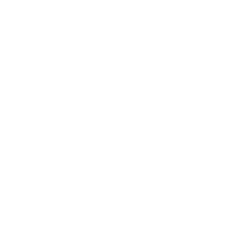

In [162]:
fig = plt.figure()
camera = Camera(fig)

for i in range(0, len(scan), 2):

    plt.imshow(scan[i], cmap = "bone")
    mask_ = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn") 
    plt.axis("off")

    camera.snap()

animation = camera.animate()

In [161]:
HTML(animation.to_html5_video())